In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] ='/content'
!kaggle datasets download -d harshghadiya/kidneystone
!unzip \*.zip && rm *.zip

  0% 0.00/1.89k [00:00<?, ?B/s]
100% 1.89k/1.89k [00:00<00:00, 2.35MB/s]
Archive:  kidneystone.zip
  inflating: kidney-stone-dataset.csv  


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Step 1: Load Data
data = pd.read_csv('/content/kidney-stone-dataset.csv')  # Replace '/path/to/your/dataset.csv' with the actual path

# Step 2: Prepare Data
X = data[['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']]
y = data['target']

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Define a function to calculate the local density for each data point
def local_density(X, k):
    distances = np.sqrt(((X[:, np.newaxis] - X) ** 2).sum(axis=2))
    k_distances = np.sort(distances, axis=1)[:, k]
    density = 1 / (k_distances + 1e-8)
    return density

# Step 6: Define a function to calculate the adaptive number of neighbors
def adaptive_neighbors(density, min_neighbors=1, max_neighbors=10):
    n_neighbors = np.round(density * (max_neighbors - min_neighbors) + min_neighbors)
    return n_neighbors.astype(int)

# Step 7: Calculate the local density for each data point in the training set
density_train = local_density(X_train_scaled, k=5)

# Step 8: Calculate the adaptive number of neighbors for each data point in the testing set
k_laknn = adaptive_neighbors(density_train, min_neighbors=1, max_neighbors=10)

# Step 9: Train the LAKNN model
laknn_models = []
for k in k_laknn:
    laknn = KNeighborsClassifier(n_neighbors=k)
    laknn.fit(X_train_scaled, y_train)
    laknn_models.append(laknn)

# Step 10: Predict using the trained LAKNN models
y_pred = []
for x_test_point, k in zip(X_test_scaled, k_laknn):
    laknn_model = laknn_models[k - 1]  # Adjust for 0-based indexing
    y_pred.append(laknn_model.predict([x_test_point])[0])

# Step 11: Evaluate the LAKNN model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Display evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8333333333333334
Precision: 0.8307692307692308
Recall: 0.8333333333333334
F1 Score: 0.829090909090909

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.80      0.67      0.73         6

    accuracy                           0.83        18
   macro avg       0.82      0.79      0.80        18
weighted avg       0.83      0.83      0.83        18



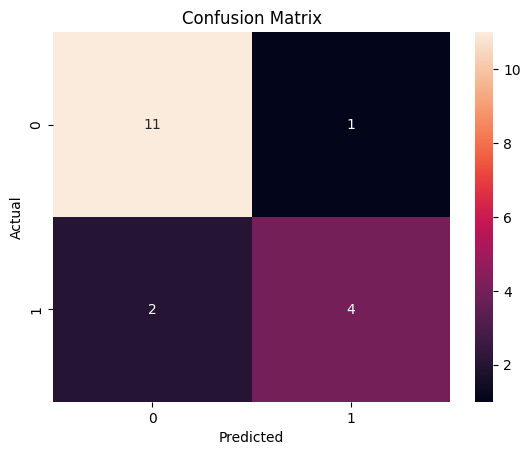

In [3]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.show()